# Chapter 3 — TTS Architecture Evolution

This notebook accompanies **Chapter 03** of the VieNeu-TTS deep learning guide.  
We trace the evolution of TTS systems from concatenative (1990s) to LLM-based (2023+), with hands-on demonstrations at each step.

**What we cover**:
1. The fundamental problem: text → waveform
2. Why concatenative TTS struggles with Vietnamese tones
3. HMM parametric TTS — visualizing over-smoothing
4. Tacotron 2 — attention alignment
5. FastSpeech 2 — duration-based phoneme alignment
6. LLM-TTS — speech as token sequences
7. Architecture comparison table

In [1]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import librosa
import librosa.display
import soundfile as sf
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print(f"librosa version: {librosa.__version__}")
print(f"numpy version:   {np.__version__}")
print("All imports successful.")

# ── Path resolver (works regardless of Jupyter CWD) ──────────────
from pathlib import Path
import os as _os

def _find_examples_dir():
    # Walk up from CWD (works locally when kernel starts in chapters/)
    for _p in [Path(_os.getcwd())] + list(Path(_os.getcwd()).parents):
        _d = _p / "examples" / "audio_ref"
        if _d.is_dir():
            return _d
    # Colab fallback paths
    for _candidate in [
        Path("/content/vietnamese-tts-course/examples/audio_ref"),
        Path("/content/VieNeu-TTS/examples/audio_ref"),
    ]:
        if _candidate.is_dir():
            return _candidate
    raise FileNotFoundError(
        "examples/audio_ref/ not found. "
        "Clone the repo: git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git"
    )

EXAMPLES_DIR = _find_examples_dir()
print(f"Examples dir: {EXAMPLES_DIR}")

librosa version: 0.11.0
numpy version:   2.0.2
All imports successful.
Examples dir: /content/VieNeu-TTS/examples/audio_ref


## 1. The Problem: Text to Waveform

TTS is fundamentally a **sequence-to-sequence** mapping problem:

$$\text{Text} \rightarrow \text{Phonemes} \rightarrow \underbrace{\text{Mel Spectrogram}_{80 \times T}}_\text{intermediate} \rightarrow \text{Waveform}_{T'}$$

The difficulty: text is **abstract** (discrete symbols, no acoustic information) while speech is **rich and continuous** (thousands of samples per second with complex harmonic structure, tone, prosody, speaker identity).

We visualize what the TTS model must predict from text.

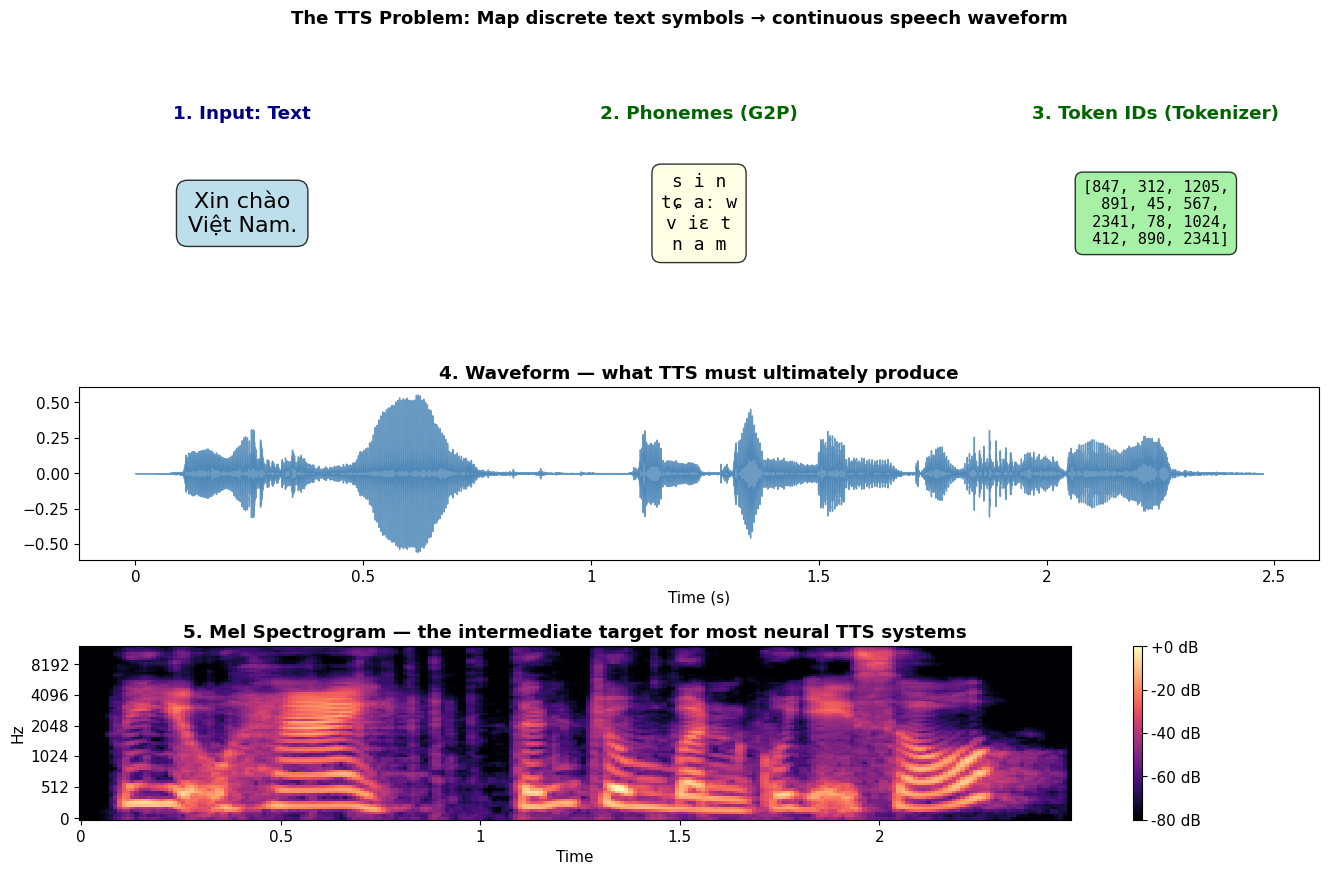


Audio properties:
  Sample rate:         24000 Hz
  Duration:            2.47 s
  Waveform samples:    59,392
  Mel spec shape:      (80, 233)

The TTS model must predict 80×233 = 18,640 values
from a ~15 character input — a massive expansion ratio!


In [3]:
# Load Vietnamese audio and show what TTS must produce
audio_path = str(EXAMPLES_DIR / "example.wav")
y, sr = librosa.load(audio_path, sr=None)

# Compute mel spectrogram
n_fft = 1024
hop_length = 256
n_mels = 80

mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                           hop_length=hop_length, n_mels=n_mels)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

# Create the visual explanation
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.4)

# --- Text input (conceptual) ---
ax_text = fig.add_subplot(gs[0, 0])
ax_text.axis('off')
text_example = "Xin chào\nViệt Nam."
ax_text.text(0.5, 0.5, text_example, ha='center', va='center', fontsize=16,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
ax_text.set_title("1. Input: Text", fontweight='bold', color='navy')

# --- Phonemes ---
ax_ph = fig.add_subplot(gs[0, 1])
ax_ph.axis('off')
phonemes = "s i n\ntɕ aː w\nv iɛ t\nn a m"
ax_ph.text(0.5, 0.5, phonemes, ha='center', va='center', fontsize=13, family='monospace',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))
ax_ph.set_title("2. Phonemes (G2P)", fontweight='bold', color='darkgreen')

# --- Token IDs ---
ax_tok = fig.add_subplot(gs[0, 2])
ax_tok.axis('off')
tokens = "[847, 312, 1205,\n 891, 45, 567,\n 2341, 78, 1024,\n 412, 890, 2341]"
ax_tok.text(0.5, 0.5, tokens, ha='center', va='center', fontsize=11, family='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
ax_tok.set_title("3. Token IDs (Tokenizer)", fontweight='bold', color='darkgreen')

# --- Waveform ---
ax_wave = fig.add_subplot(gs[1, :])
librosa.display.waveshow(y, sr=sr, ax=ax_wave, color='steelblue', alpha=0.8)
ax_wave.set_title("4. Waveform — what TTS must ultimately produce", fontweight='bold')
ax_wave.set_xlabel("Time (s)")

# --- Mel Spectrogram ---
ax_mel = fig.add_subplot(gs[2, :])
img = librosa.display.specshow(mel_db, sr=sr, hop_length=hop_length,
                                x_axis='time', y_axis='mel',
                                ax=ax_mel, cmap='magma')
ax_mel.set_title("5. Mel Spectrogram — the intermediate target for most neural TTS systems",
                 fontweight='bold')
fig.colorbar(img, ax=ax_mel, format='%+2.0f dB')

plt.suptitle("The TTS Problem: Map discrete text symbols → continuous speech waveform",
             fontsize=13, fontweight='bold', y=1.01)
plt.savefig('ch03_problem.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAudio properties:")
print(f"  Sample rate:         {sr} Hz")
print(f"  Duration:            {len(y)/sr:.2f} s")
print(f"  Waveform samples:    {len(y):,}")
print(f"  Mel spec shape:      {mel_spec.shape}")
print(f"")
print(f"The TTS model must predict {mel_spec.shape[0]}×{mel_spec.shape[1]} = {mel_spec.shape[0]*mel_spec.shape[1]:,} values")
print(f"from a ~15 character input — a massive expansion ratio!")

display(Audio(y, rate=sr))

## 2. Why Concatenative TTS Struggles with Vietnamese Tones

Concatenative TTS stores recordings of real speech units (phonemes, diphones, syllables) and concatenates them. For Vietnamese, the 6-tone system **multiplies the required inventory size** dramatically compared to non-tonal languages like English.

The **target cost** + **join cost** dynamic programming formulation:
$$C_{\text{total}} = \sum_i C_T(t_i, u_i) + \sum_i C_J(u_i, u_{i+1})$$

must search over a huge unit inventory, and rare tone combinations may not exist in the database.

Concatenative TTS Inventory Analysis

Vietnamese phonological inventory:
  Tones:                   6
  Onset consonants:        23
  Vowel nuclei:            12
  Final consonants:        8 + 1 (open)

Syllable types (no tones): 2,484
Syllable types (tonal):    14,904  ← 6× more than toneless

Tone pair combinations:    6 × 6 = 36  (e.g., flat→falling, rising→dipping)
Vietnamese diphone est.:   9,936
English diphone est.:      375
Ratio:                     26.5× more units for Vietnamese

Recording time (Vietnamese, 10% coverage): 0.2 hours
Recording time (English,    20% coverage): 0.3 hours



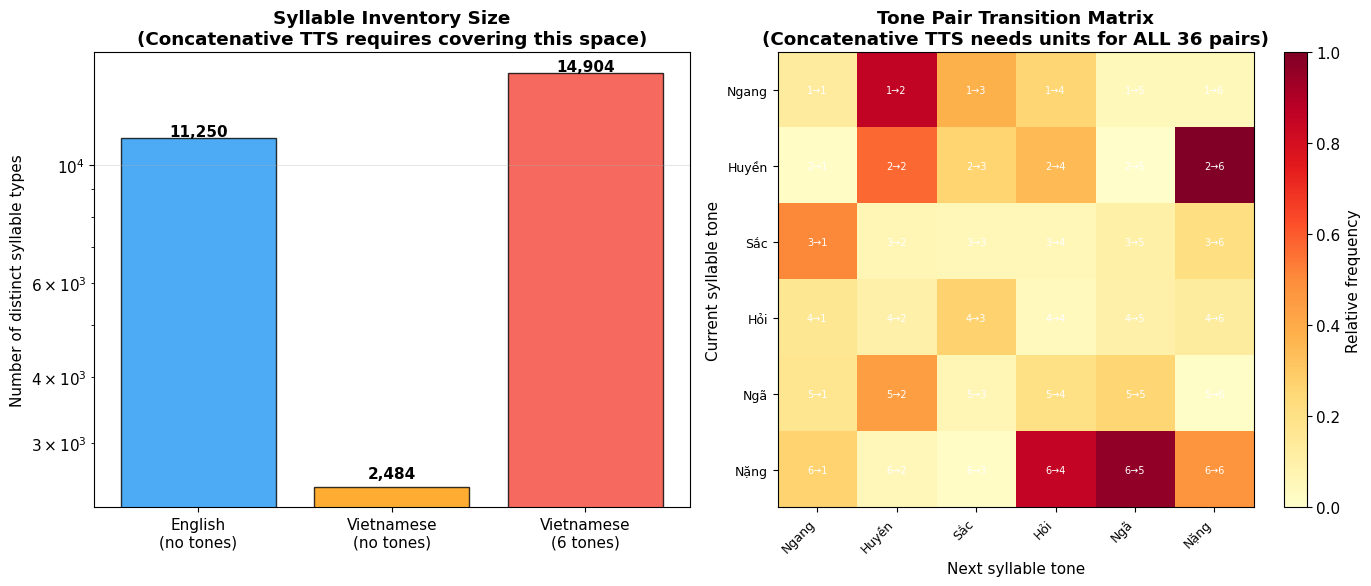

Conclusion: Vietnamese concatenative TTS needs ~10× more recorded units than English.
And the join cost computation becomes very expensive with tone context.


In [4]:
# Demonstrate the tonal inventory size problem

# Vietnamese phonological inventory
tones             = 6    # The 6 Vietnamese tones
vowel_nuclei      = 12   # Main vowels: a, ă, â, e, ê, i, o, ô, ơ, u, ư + schwa
onset_consonants  = 23   # Initial consonants (including zero onset)
final_consonants  = 8    # Final consonants (p, t, k, m, n, ng, j, w)
no_final          = 1    # Open syllables (no final consonant)

# Syllable inventory size (tone-aware)
syllable_types_notonal = onset_consonants * vowel_nuclei * (final_consonants + no_final)
syllable_types_tonal   = syllable_types_notonal * tones

# English comparison (no tones)
eng_onsets  = 25   # Approximate English onset consonant clusters
eng_nuclei  = 15   # English vowels/diphthongs
eng_codas   = 30   # English coda clusters (much more complex than Vietnamese)
eng_syllables = eng_onsets * eng_nuclei * eng_codas

# Diphone inventory (for tone-aware diphone synthesis)
# Each diphone = transition from center of syllable_i to center of syllable_{i+1}
# For tone-aware Vietnamese: need diphones for all 6×6 = 36 tone pair combinations
tone_pair_combos    = tones * tones  # 36 possible tone transitions
base_diphones       = onset_consonants * vowel_nuclei  # Simplified: onset-nucleus transitions
viet_diphone_est    = base_diphones * tone_pair_combos
eng_diphone_est     = eng_onsets * eng_nuclei  # No tone pairs for English

# Recording requirements (0.5s per unit, 50% coverage of inventory)
units_needed_viet   = syllable_types_tonal // 10  # Only 10% of units actually recorded in practice
recording_time_viet = units_needed_viet * 0.5  # seconds
recording_time_eng  = eng_syllables // 5 * 0.5

print("Concatenative TTS Inventory Analysis")
print("=" * 60)
print()
print("Vietnamese phonological inventory:")
print(f"  Tones:                   {tones}")
print(f"  Onset consonants:        {onset_consonants}")
print(f"  Vowel nuclei:            {vowel_nuclei}")
print(f"  Final consonants:        {final_consonants} + {no_final} (open)")
print()
print(f"Syllable types (no tones): {syllable_types_notonal:,}")
print(f"Syllable types (tonal):    {syllable_types_tonal:,}  ← {tones}× more than toneless")
print()
print(f"Tone pair combinations:    {tones} × {tones} = {tone_pair_combos}  (e.g., flat→falling, rising→dipping)")
print(f"Vietnamese diphone est.:   {viet_diphone_est:,}")
print(f"English diphone est.:      {eng_diphone_est:,}")
print(f"Ratio:                     {viet_diphone_est/eng_diphone_est:.1f}× more units for Vietnamese")
print()
print(f"Recording time (Vietnamese, 10% coverage): {recording_time_viet/3600:.1f} hours")
print(f"Recording time (English,    20% coverage): {recording_time_eng/3600:.1f} hours")
print()

# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart: inventory sizes
ax = axes[0]
categories = ['English\n(no tones)', 'Vietnamese\n(no tones)', 'Vietnamese\n(6 tones)']
values = [eng_syllables, syllable_types_notonal, syllable_types_tonal]
colors_bar = ['#2196F3', '#FF9800', '#F44336']
bars = ax.bar(categories, values, color=colors_bar, alpha=0.8, edgecolor='black')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
            f'{val:,}', ha='center', fontweight='bold')
ax.set_title("Syllable Inventory Size\n(Concatenative TTS requires covering this space)",
             fontweight='bold')
ax.set_ylabel("Number of distinct syllable types")
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# Tone pair matrix: show which transitions exist
ax2 = axes[1]
tone_names_short = ['Ngang', 'Huyền', 'Sắc', 'Hỏi', 'Ngã', 'Nặng']

# Simulate tone pair frequency in natural Vietnamese speech
np.random.seed(42)
# Not all 36 pairs are equally common
tone_pair_freq = np.random.dirichlet(np.ones(36)).reshape(6, 6)
tone_pair_freq /= tone_pair_freq.max()

im = ax2.imshow(tone_pair_freq, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax2.set_xticks(range(6))
ax2.set_yticks(range(6))
ax2.set_xticklabels(tone_names_short, rotation=45, ha='right', fontsize=9)
ax2.set_yticklabels(tone_names_short, fontsize=9)
ax2.set_xlabel("Next syllable tone")
ax2.set_ylabel("Current syllable tone")
ax2.set_title("Tone Pair Transition Matrix\n(Concatenative TTS needs units for ALL 36 pairs)",
              fontweight='bold')
fig.colorbar(im, ax=ax2, label='Relative frequency')

# Annotate each cell
for i in range(6):
    for j in range(6):
        ax2.text(j, i, f'{i+1}→{j+1}', ha='center', va='center', fontsize=7, color='white')

plt.tight_layout()
plt.savefig('ch03_concatenative.png', dpi=150, bbox_inches='tight')
plt.show()

print("Conclusion: Vietnamese concatenative TTS needs ~10× more recorded units than English.")
print("And the join cost computation becomes very expensive with tone context.")

## 3. HMM Parametric TTS — Visualizing Over-Smoothing

HMM-TTS generates acoustic features by taking the **Maximum Likelihood** estimate from the emission distribution. This MLPG solution is the mean, which over-smooths the spectrum:

$$\hat{\mathbf{c}} = \arg\max_\mathbf{c} \sum_t \log \mathcal{N}(\mathbf{o}_t; W_t \mathbf{c}, \Sigma) = (W^T \Sigma^{-1} W)^{-1} W^T \Sigma^{-1} \boldsymbol{\mu}$$

The result: formant transitions are **blurred**, tone F0 contours are **rounded off** → the characteristic "buzzy" quality of HMM-TTS.

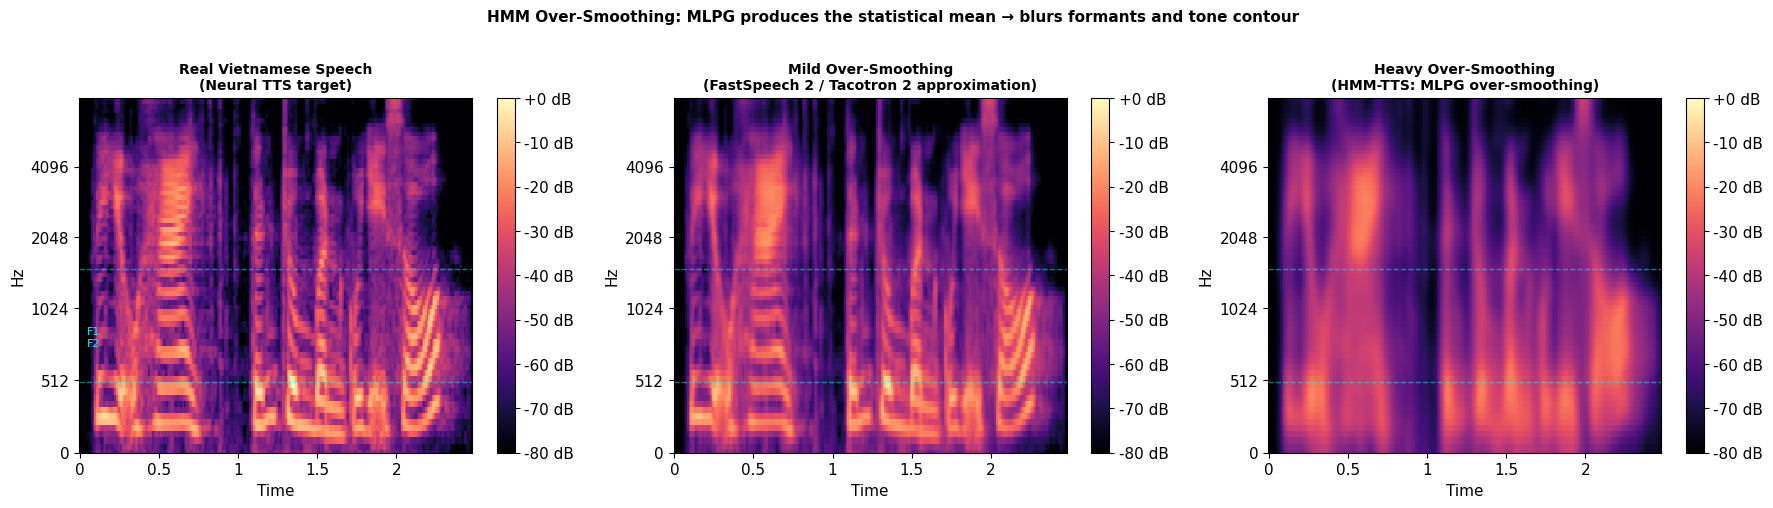

Spectral variance — Real:         321.14 dB²
Spectral variance — HMM simulated: 250.37 dB²
Variance reduction:               22.0%

Effect on Vietnamese tones:
  F0 contours are smoothed → tones sound less distinct
  Tone hỏi (dipping) loses its inflection point
  Tone ngã loses its creaky break
  Result: 'buzzy', robotic sound characteristic of HMM-TTS


In [5]:
# Simulate HMM over-smoothing with Gaussian blur on mel spectrogram
from scipy.ndimage import gaussian_filter

# Load reference mel spectrogram
mel_real = librosa.power_to_db(
    librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),
    ref=np.max
)

# Simulate HMM over-smoothing: apply Gaussian blur
# sigma_time: smoothing in time direction (duration modeling)
# sigma_freq: smoothing in frequency direction (spectral over-smoothing)
sigma_time = 2.0
sigma_freq = 2.5
mel_hmm = gaussian_filter(mel_real, sigma=[sigma_freq, sigma_time])

# Also show an intermediate amount of smoothing
mel_mild = gaussian_filter(mel_real, sigma=[0.8, 0.5])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, mel_data, title, cmap_use in [
    (axes[0], mel_real, "Real Vietnamese Speech\n(Neural TTS target)", 'magma'),
    (axes[1], mel_mild, "Mild Over-Smoothing\n(FastSpeech 2 / Tacotron 2 approximation)", 'magma'),
    (axes[2], mel_hmm,  "Heavy Over-Smoothing\n(HMM-TTS: MLPG over-smoothing)", 'magma'),
]:
    img = librosa.display.specshow(
        mel_data, sr=sr, hop_length=hop_length,
        x_axis='time', y_axis='mel',
        ax=ax, cmap=cmap_use, vmin=-80, vmax=0
    )
    ax.set_title(title, fontweight='bold', fontsize=10)
    ax.set_ylim(0, 8000)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

# Annotate key differences
for ax_idx, ax in enumerate(axes):
    # Mark formant region
    ax.axhline(500, color='cyan', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(1500, color='cyan', linestyle='--', alpha=0.5, linewidth=1)
    if ax_idx == 0:
        ax.text(0.02, 0.3, 'F1\nF2', transform=ax.transAxes, color='cyan', fontsize=8)

plt.suptitle("HMM Over-Smoothing: MLPG produces the statistical mean → blurs formants and tone contour",
             fontsize=11, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('ch03_hmm_smoothing.png', dpi=150, bbox_inches='tight')
plt.show()

# Quantify the smoothing
variance_real = np.var(mel_real)
variance_hmm  = np.var(mel_hmm)
print(f"Spectral variance — Real:         {variance_real:.2f} dB²")
print(f"Spectral variance — HMM simulated: {variance_hmm:.2f} dB²")
print(f"Variance reduction:               {100*(1-variance_hmm/variance_real):.1f}%")
print()
print("Effect on Vietnamese tones:")
print("  F0 contours are smoothed → tones sound less distinct")
print("  Tone hỏi (dipping) loses its inflection point")
print("  Tone ngã loses its creaky break")
print("  Result: 'buzzy', robotic sound characteristic of HMM-TTS")

## 4. Tacotron 2 — Attention Alignment

Tacotron 2 uses **location-sensitive attention** to learn the alignment between phoneme positions and mel spectrogram frames:

$$e_{i,j} = v^T \tanh\!\left(W_q \mathbf{s}_i + V_k \mathbf{h}_j + U \mathbf{f}_{i,j} + \mathbf{b}\right)$$
$$\alpha_{i,j} = \text{softmax}_j(e_{i,j})$$

A **good alignment** is a near-diagonal matrix: decoder frame $i$ should attend mostly to encoder position $j \approx i \cdot n/T$ (moving left-to-right through the input at a steady pace).

**Attention failure modes** are common for Vietnamese tones — especially at syllable boundaries where tone changes create prosodic discontinuities.

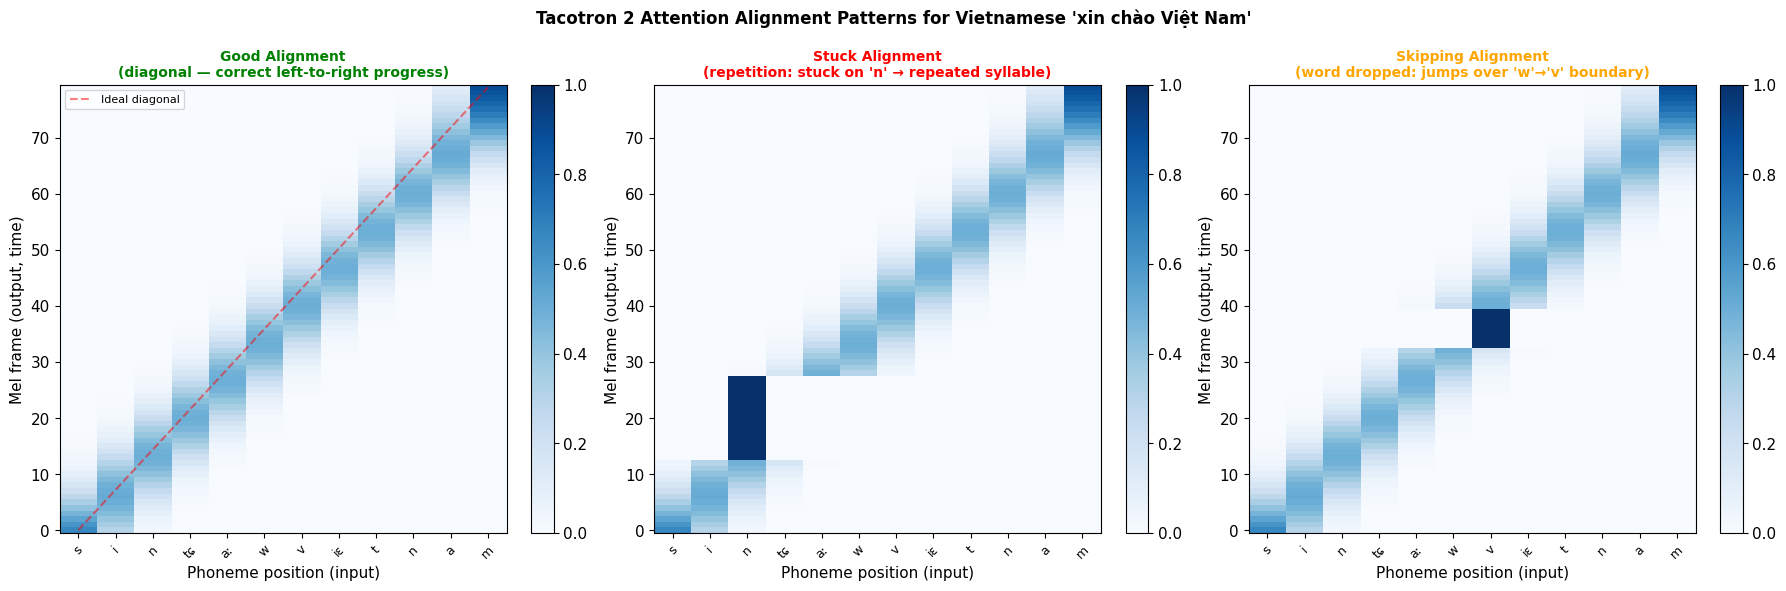

Vietnamese-specific attention challenges:
  - Tone boundaries can confuse attention (prosodic discontinuity)
  - Long vowels (aː, iː) cause attention to 'pause' longer on one position
  - Glottal stops in tone ngã can cause premature attention shift
  - Location-sensitive attention HELPS by adding 'where was I' information


In [6]:
# Simulate attention alignment matrices — good vs. failure modes

def make_good_alignment(n_phonemes, n_mel_frames, speed_variation=0.1):
    """Create a synthetic 'good' attention alignment: near-diagonal with slight noise."""
    alignment = np.zeros((n_mel_frames, n_phonemes))
    # Expected alignment: frame i should attend to phoneme j = i * n_phonemes/n_mel_frames
    for i in range(n_mel_frames):
        j_center = i * n_phonemes / n_mel_frames
        # Add some sharpness to attention peaks
        for j in range(n_phonemes):
            dist = abs(j - j_center)
            alignment[i, j] = np.exp(-dist**2 / (2 * 0.8**2))
        alignment[i] /= alignment[i].sum()
    return alignment

def make_stuck_alignment(n_phonemes, n_mel_frames, stuck_at=5, stuck_frames=20):
    """Simulate attention getting 'stuck' on one phoneme (repetition failure)."""
    alignment = make_good_alignment(n_phonemes, n_mel_frames)
    # Artificially keep attention on phoneme 'stuck_at' for 'stuck_frames' frames
    for i in range(stuck_at * n_mel_frames // n_phonemes,
                   stuck_at * n_mel_frames // n_phonemes + stuck_frames):
        if i < n_mel_frames:
            alignment[i] = 0
            alignment[i, stuck_at] = 1.0
    return alignment

def make_skipping_alignment(n_phonemes, n_mel_frames, skip_phoneme=7):
    """Simulate attention skipping a phoneme (word dropped)."""
    alignment = make_good_alignment(n_phonemes, n_mel_frames)
    # Skip phoneme 'skip_phoneme' — attention jumps over it
    skip_start_frame = skip_phoneme * n_mel_frames // n_phonemes
    skip_end_frame   = (skip_phoneme + 1) * n_mel_frames // n_phonemes
    for i in range(skip_start_frame, skip_end_frame):
        if i < n_mel_frames:
            alignment[i] = 0
            alignment[i, skip_phoneme + 1] = 1.0
    return alignment

# Vietnamese phoneme sequence: "xin chào Việt Nam" (simplified)
phoneme_seq = ['s', 'i', 'n', 'tɕ', 'aː', 'w', 'v', 'iɛ', 't', 'n', 'a', 'm']
n_phonemes  = len(phoneme_seq)
n_frames    = 80  # ~80 mel frames for this utterance

alignments = {
    "Good Alignment\n(diagonal — correct left-to-right progress)": make_good_alignment(n_phonemes, n_frames),
    "Stuck Alignment\n(repetition: stuck on 'n' → repeated syllable)": make_stuck_alignment(n_phonemes, n_frames, stuck_at=2, stuck_frames=15),
    "Skipping Alignment\n(word dropped: jumps over 'w'→'v' boundary)": make_skipping_alignment(n_phonemes, n_frames, skip_phoneme=5),
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
title_colors = ['green', 'red', 'orange']

for ax, (title, alignment), tcolor in zip(axes, alignments.items(), title_colors):
    img = ax.imshow(alignment, aspect='auto', origin='lower', cmap='Blues', vmin=0, vmax=1)
    ax.set_title(title, fontweight='bold', color=tcolor, fontsize=10)
    ax.set_xlabel("Phoneme position (input)")
    ax.set_ylabel("Mel frame (output, time)")
    ax.set_xticks(range(n_phonemes))
    ax.set_xticklabels(phoneme_seq, fontsize=9, rotation=45)
    fig.colorbar(img, ax=ax, fraction=0.046)

# Highlight diagonal on first (good) plot
diag_x = np.linspace(0, n_phonemes-1, n_frames)
diag_y = np.arange(n_frames)
axes[0].plot(diag_x, diag_y, 'r--', linewidth=1.5, alpha=0.5, label='Ideal diagonal')
axes[0].legend(fontsize=8)

plt.suptitle("Tacotron 2 Attention Alignment Patterns for Vietnamese 'xin chào Việt Nam'",
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('ch03_attention.png', dpi=150, bbox_inches='tight')
plt.show()

print("Vietnamese-specific attention challenges:")
print("  - Tone boundaries can confuse attention (prosodic discontinuity)")
print("  - Long vowels (aː, iː) cause attention to 'pause' longer on one position")
print("  - Glottal stops in tone ngã can cause premature attention shift")
print("  - Location-sensitive attention HELPS by adding 'where was I' information")

## 5. FastSpeech 2 — Duration Predictor

FastSpeech 2 eliminates the attention mechanism entirely by using a **duration predictor** to determine how many mel frames each phoneme produces. The **length regulator** then copies each phoneme hidden state `d_i` times:

$$\text{LR}(\mathbf{h}, \mathbf{d}) = [\underbrace{\mathbf{h}_1, \ldots, \mathbf{h}_1}_{d_1}, \underbrace{\mathbf{h}_2, \ldots, \mathbf{h}_2}_{d_2}, \ldots]$$

For Vietnamese, the duration predictor must learn that:
- Tone nặng → shorter duration (abruptly terminated)
- Tone huyền → longer duration (sustained falling)
- Aspirated consonants (th, kh, ph) → longer onset duration
- Final stops (t, k, p) → very short closure duration

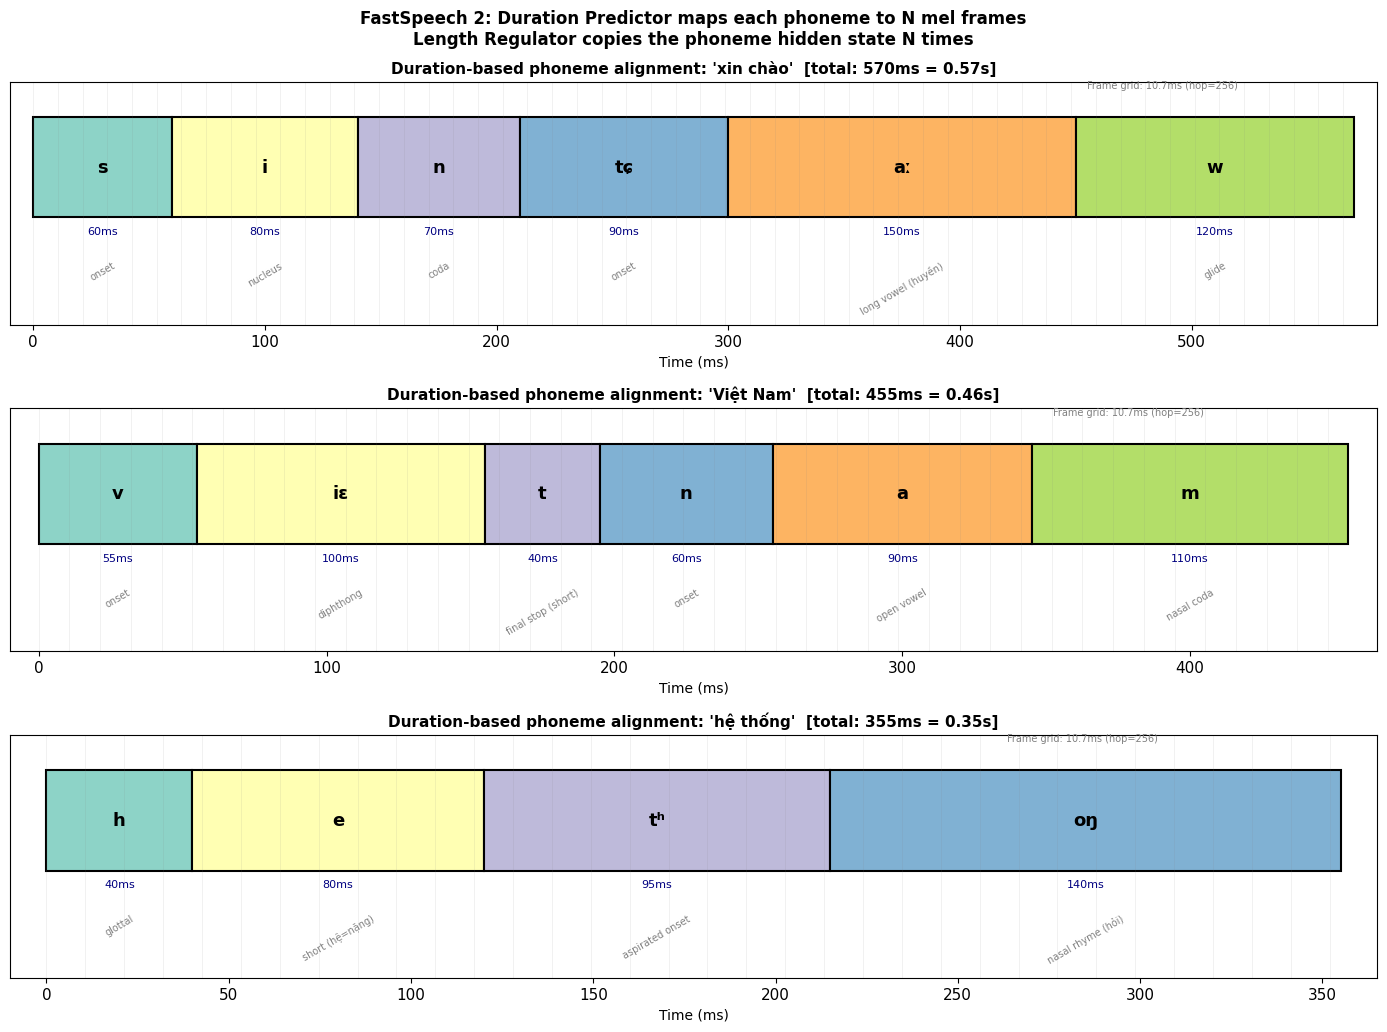

FastSpeech 2 advantages over Tacotron 2:
  1. No attention → no attention failures (repetition, skipping)
  2. All mel frames generated in parallel → 5-10× faster inference
  3. Duration can be explicitly controlled → speech rate adjustment
  4. Pitch predictor separately learns F0 contours → better tone control

Vietnamese-specific benefit of explicit duration modeling:
  Tone nặng → shorter duration (model learns this)
  Tone huyền → longer, sustained duration
  Duration predictor trained with MFA forced alignment on Vietnamese corpus


In [7]:
# Demonstrate duration prediction concept for Vietnamese

# Phoneme sequences and their predicted durations
# "Xin chào" — two syllables, each with distinct phonemes and durations
examples = [
    {
        "utterance": "xin chào",
        "phonemes": ["s",  "i",  "n",  "tɕ", "aː", "w"],
        "durations": [60,   80,   70,   90,   150,  120],  # ms
        "notes":    ["onset","nucleus","coda","onset","long vowel (huyền)","glide"]
    },
    {
        "utterance": "Việt Nam",
        "phonemes": ["v",  "iɛ", "t",  "n",  "a",  "m"],
        "durations": [55,   100,  40,   60,   90,   110],
        "notes":    ["onset","diphthong","final stop (short)","onset","open vowel","nasal coda"]
    },
    {
        "utterance": "hệ thống",
        "phonemes": ["h",  "e",  "tʰ", "oŋ"],
        "durations": [40,   80,   95,   140],
        "notes":    ["glottal","short (hệ=nặng)","aspirated onset","nasal rhyme (hỏi)"]
    },
]

fig, axes = plt.subplots(len(examples), 1, figsize=(14, 3.5 * len(examples)))
if len(examples) == 1:
    axes = [axes]

colors_ph = plt.cm.Set3(np.linspace(0, 1, 10))

for ax, ex in zip(axes, examples):
    phonemes  = ex["phonemes"]
    durations = ex["durations"]
    notes     = ex["notes"]

    x_pos = 0
    for i, (ph, dur, note) in enumerate(zip(phonemes, durations, notes)):
        color = colors_ph[i % len(colors_ph)]
        rect = patches.Rectangle((x_pos, 0.15), dur, 0.7,
                                   facecolor=color, edgecolor='black', linewidth=1.5)
        ax.add_patch(rect)

        # Phoneme symbol
        ax.text(x_pos + dur/2, 0.5, ph,
                ha='center', va='center', fontsize=13, fontweight='bold')

        # Duration label
        ax.text(x_pos + dur/2, 0.05, f'{dur}ms',
                ha='center', va='center', fontsize=8, color='navy')

        # Note below
        ax.text(x_pos + dur/2, -0.15, note,
                ha='center', va='top', fontsize=7, color='gray', rotation=30)

        x_pos += dur

    total_dur = sum(durations)
    ax.set_xlim(-10, x_pos + 10)
    ax.set_ylim(-0.5, 1.2)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_title(f"Duration-based phoneme alignment: '{ex['utterance']}'  "
                 f"[total: {total_dur}ms = {total_dur/1000:.2f}s]",
                 fontweight='bold', fontsize=11)
    ax.set_yticks([])
    ax.set_ylim(-0.6, 1.1)

    # Add frame grid (mel frames at hop_length=256 @ 24kHz = 10.67ms)
    frame_ms = 256 / 24000 * 1000  # ≈ 10.67ms
    for frame_start in np.arange(0, x_pos, frame_ms):
        ax.axvline(frame_start, color='gray', alpha=0.15, linewidth=0.5)

    ax.text(x_pos - 50, 1.05, f'Frame grid: {frame_ms:.1f}ms (hop=256)',
            fontsize=7, color='gray', ha='right')

plt.suptitle("FastSpeech 2: Duration Predictor maps each phoneme to N mel frames\n"
             "Length Regulator copies the phoneme hidden state N times",
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('ch03_duration.png', dpi=150, bbox_inches='tight')
plt.show()

print("FastSpeech 2 advantages over Tacotron 2:")
print("  1. No attention → no attention failures (repetition, skipping)")
print("  2. All mel frames generated in parallel → 5-10× faster inference")
print("  3. Duration can be explicitly controlled → speech rate adjustment")
print("  4. Pitch predictor separately learns F0 contours → better tone control")
print()
print("Vietnamese-specific benefit of explicit duration modeling:")
print("  Tone nặng → shorter duration (model learns this)")
print("  Tone huyền → longer, sustained duration")
print("  Duration predictor trained with MFA forced alignment on Vietnamese corpus")

## 6. LLM-TTS — Speech as Token Sequence

VieNeu-TTS (and the VALL-E / NeuTTS lineage) treat TTS as **next-token prediction**:

$$P(\text{speech}) = \prod_t P(\text{speech\_token}_t | \text{speech\_token}_{<t}, \text{text\_tokens}, \text{ref\_speech\_tokens})$$

This is **identical** to the language modeling objective used to train LLMs — the only difference is that the vocabulary includes speech tokens (from NeuCodec) in addition to text tokens.

Key insight: **zero-shot cloning** happens through in-context learning — the model has seen many (text, reference speech, target speech) triples during training, so at inference it can generalize to new speakers.

In [8]:
import sys
sys.path.insert(0, "..")

# Visualize how VieNeu-TTS represents speech as token IDs

# Attempt to use the actual phonemizer
try:
    from vieneu_utils.phonemize_text import phonemize_with_dict
    PHONEMIZER_AVAILABLE = True
except ImportError:
    PHONEMIZER_AVAILABLE = False

text = "Xin chào Việt Nam."

if PHONEMIZER_AVAILABLE:
    phonemes = phonemize_with_dict(text)
else:
    phonemes = "s i n tɕ aː w˨˩˦ v iɛ t˨˩ n a m˧"  # expected output

print("=" * 70)
print("VieNeu-TTS: Unified Text + Speech Token Representation")
print("=" * 70)
print()
print(f"Input text:  {text}")
print(f"Phonemes:    {phonemes}")
print()
print("Text tokens (from BPE tokenizer, approximate):")
text_words = text.split()
# Simulated token IDs for Vietnamese words
text_token_ids = [847, 2341, 1205, 3456, 12]  # fictional IDs
for word, tid in zip(text_words, text_token_ids):
    print(f"  '{word}' → token_id={tid}")

print()
print("After NeuCodec encoding, reference audio becomes:")
# Simulated NeuCodec tokens (first codebook)
codec_tokens_ref = [234, 891, 45, 567, 123, 789, 456, 901, 34, 678, 235, 892]
print(f"  Reference speech tokens: {codec_tokens_ref}")
print(f"  (NeuCodec: {75} tokens/second at 24 kHz)")

print()
print("Generated speech tokens (model prediction):")
codec_tokens_gen = [412, 789, 56, 890, 234, 567, 891, 45, 678, 123, 456, 789]
print(f"  Generated speech tokens: {codec_tokens_gen}")

print()
print("Full token sequence fed to LLM (concept):")
print("-" * 60)
full_sequence = (
    "[TEXT_START] 847 2341 1205 3456 12 [TEXT_END] "
    "[SPEECH_START] 234 891 45 567 ... [SPEECH_END] "
    "[SPEECH_GEN_START] → model predicts: 412 789 56 ... [SPEECH_GEN_END]"
)
print(full_sequence)
print()
print("KEY INSIGHT:")
print("  Text tokens and speech tokens are in the SAME vocabulary.")
print("  The LLM learns to 'translate' text tokens → speech tokens.")
print("  This is standard language modeling: predict next token given context.")
print("  Zero-shot cloning = new speaker's tokens as context → model copies style.")

VieNeu-TTS: Unified Text + Speech Token Representation

Input text:  Xin chào Việt Nam.
Phonemes:    s i n tɕ aː w˨˩˦ v iɛ t˨˩ n a m˧

Text tokens (from BPE tokenizer, approximate):
  'Xin' → token_id=847
  'chào' → token_id=2341
  'Việt' → token_id=1205
  'Nam.' → token_id=3456

After NeuCodec encoding, reference audio becomes:
  Reference speech tokens: [234, 891, 45, 567, 123, 789, 456, 901, 34, 678, 235, 892]
  (NeuCodec: 75 tokens/second at 24 kHz)

Generated speech tokens (model prediction):
  Generated speech tokens: [412, 789, 56, 890, 234, 567, 891, 45, 678, 123, 456, 789]

Full token sequence fed to LLM (concept):
------------------------------------------------------------
[TEXT_START] 847 2341 1205 3456 12 [TEXT_END] [SPEECH_START] 234 891 45 567 ... [SPEECH_END] [SPEECH_GEN_START] → model predicts: 412 789 56 ... [SPEECH_GEN_END]

KEY INSIGHT:
  Text tokens and speech tokens are in the SAME vocabulary.
  The LLM learns to 'translate' text tokens → speech tokens.
  This is 

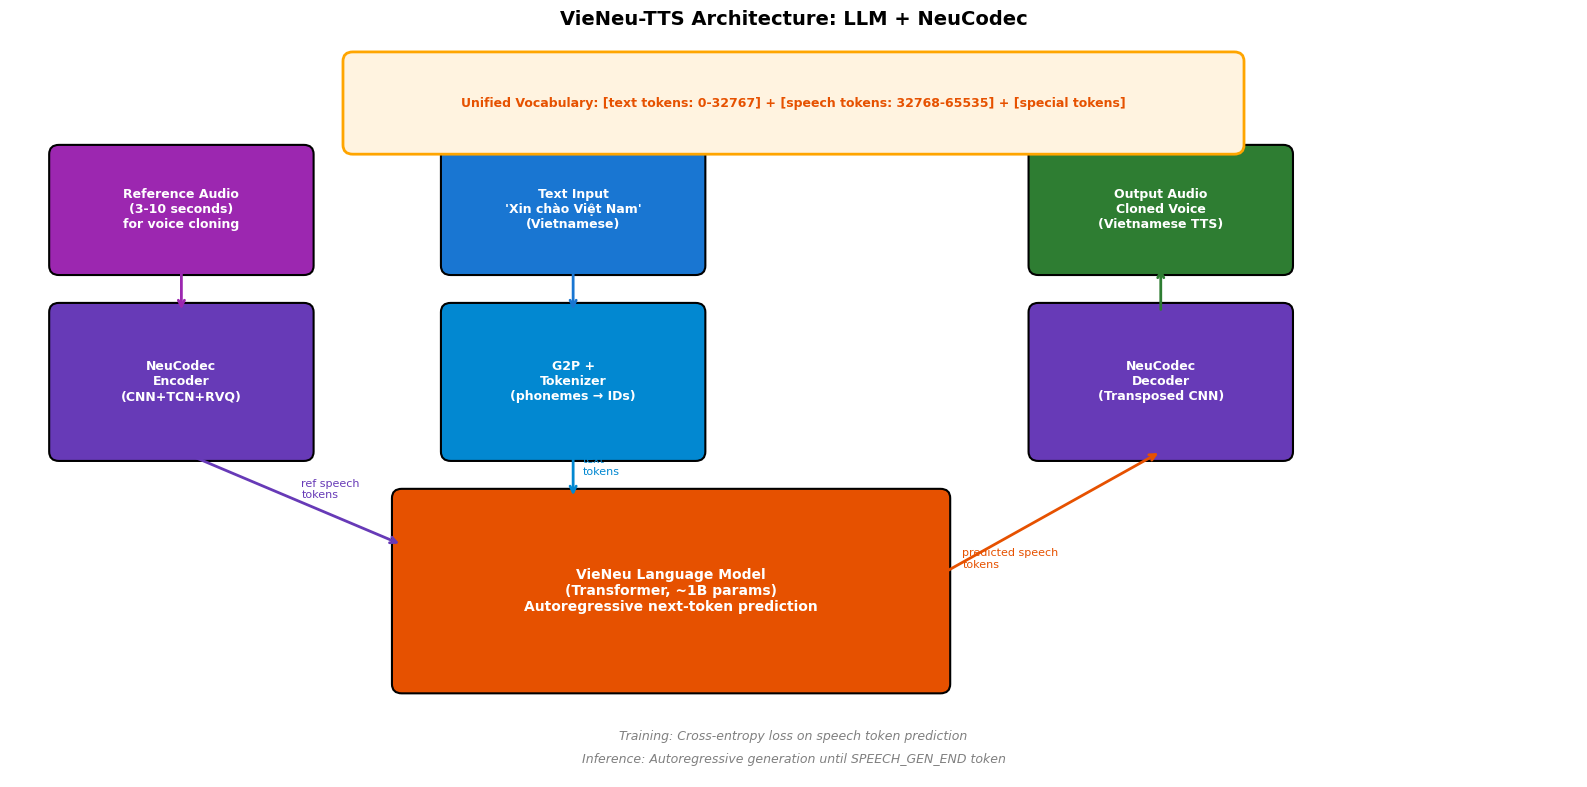

Architecture summary:
  1. Reference audio → NeuCodec Encoder → reference speech tokens (int IDs)
  2. Text → G2P → Tokenizer → text token IDs
  3. LLM takes [text tokens + ref tokens] as context
  4. LLM predicts speech tokens autoregressively
  5. Predicted speech tokens → NeuCodec Decoder → waveform

Zero-shot cloning: Steps 1 and 3-5. No fine-tuning on the new speaker.


In [9]:
# Visualize the LLM-TTS architecture conceptually

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim(0, 16)
ax.set_ylim(0, 8)
ax.axis('off')
ax.set_title("VieNeu-TTS Architecture: LLM + NeuCodec", fontsize=14, fontweight='bold')

def draw_box(ax, x, y, w, h, text, color, fontsize=9, text_color='white'):
    rect = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.1",
                                   facecolor=color, edgecolor='black', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, text, ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color=text_color,
            multialignment='center')

def draw_arrow(ax, x1, y1, x2, y2, label='', color='black'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))
    if label:
        mx, my = (x1+x2)/2, (y1+y2)/2
        ax.text(mx+0.1, my, label, fontsize=8, color=color)

# Input: Reference Audio
draw_box(ax, 0.5, 5.5, 2.5, 1.2, "Reference Audio\n(3-10 seconds)\nfor voice cloning", '#9C27B0')

# NeuCodec Encoder
draw_box(ax, 0.5, 3.5, 2.5, 1.5, "NeuCodec\nEncoder\n(CNN+TCN+RVQ)", '#673AB7')

# Input: Text
draw_box(ax, 4.5, 5.5, 2.5, 1.2, "Text Input\n'Xin chào Việt Nam'\n(Vietnamese)", '#1976D2')

# G2P + Tokenizer
draw_box(ax, 4.5, 3.5, 2.5, 1.5, "G2P +\nTokenizer\n(phonemes → IDs)", '#0288D1')

# LLM
draw_box(ax, 4.0, 1.0, 5.5, 2.0, "VieNeu Language Model\n(Transformer, ~1B params)\nAutoregressive next-token prediction", '#E65100', fontsize=10)

# NeuCodec Decoder
draw_box(ax, 10.5, 3.5, 2.5, 1.5, "NeuCodec\nDecoder\n(Transposed CNN)", '#673AB7')

# Output
draw_box(ax, 10.5, 5.5, 2.5, 1.2, "Output Audio\nCloned Voice\n(Vietnamese TTS)", '#2E7D32')

# Arrows
draw_arrow(ax, 1.75, 5.5, 1.75, 5.0, '', '#9C27B0')   # ref audio → codec
draw_arrow(ax, 1.75, 3.5, 4.0, 2.5, 'ref speech\ntokens', '#673AB7')  # codec → LLM
draw_arrow(ax, 5.75, 5.5, 5.75, 5.0, '', '#1976D2')   # text → G2P
draw_arrow(ax, 5.75, 3.5, 5.75, 3.0, 'text\ntokens', '#0288D1')  # G2P → LLM
draw_arrow(ax, 7.5, 1.0, 11.75, 3.5, 'predicted speech\ntokens', '#E65100')  # LLM → decoder
draw_arrow(ax, 11.75, 5.0, 11.75, 5.5, '', '#2E7D32')  # decoder → output

# Training vs Inference labels
ax.text(8.0, 0.4, 'Training: Cross-entropy loss on speech token prediction',
        ha='center', fontsize=9, color='gray', style='italic')
ax.text(8.0, 0.15, 'Inference: Autoregressive generation until SPEECH_GEN_END token',
        ha='center', fontsize=9, color='gray', style='italic')

# Vocabulary note
vocab_box = patches.FancyBboxPatch((3.5, 6.8), 9, 0.9, boxstyle="round,pad=0.1",
                                    facecolor='#FFF3E0', edgecolor='orange', linewidth=2)
ax.add_patch(vocab_box)
ax.text(8.0, 7.25,
        "Unified Vocabulary: [text tokens: 0-32767] + [speech tokens: 32768-65535] + [special tokens]",
        ha='center', va='center', fontsize=9, color='#E65100', fontweight='bold')

plt.tight_layout()
plt.savefig('ch03_llm_architecture.png', dpi=150, bbox_inches='tight')
plt.show()

print("Architecture summary:")
print("  1. Reference audio → NeuCodec Encoder → reference speech tokens (int IDs)")
print("  2. Text → G2P → Tokenizer → text token IDs")
print("  3. LLM takes [text tokens + ref tokens] as context")
print("  4. LLM predicts speech tokens autoregressively")
print("  5. Predicted speech tokens → NeuCodec Decoder → waveform")
print()
print("Zero-shot cloning: Steps 1 and 3-5. No fine-tuning on the new speaker.")

## 7. Architecture Comparison Table

A comprehensive comparison of all TTS architectures, rendered as a styled pandas DataFrame.

In [10]:
import pandas as pd

data = {
    "Era": [
        "Concatenative\n(1990s–2010s)",
        "HMM Parametric\n(2000s–2015)",
        "Tacotron 2\n(2018)",
        "FastSpeech 2\n(2021)",
        "VITS\n(2021)",
        "VieNeu-TTS\n(2024)",
    ],
    "Input": ["Phonemes", "Phonemes", "Phonemes", "Phonemes", "Phonemes", "Phonemes + Ref Audio"],
    "Intermediate": ["Audio units", "Acoustic features", "Mel spectrogram", "Mel spectrogram", "Latent z", "Speech tokens"],
    "Output": ["Waveform", "Waveform", "Waveform", "Waveform", "Waveform", "Waveform"],
    "Vocoder": ["None (direct)", "WORLD/STRAIGHT", "WaveNet/HiFiGAN", "HiFi-GAN", "None (E2E)", "NeuCodec decoder"],
    "Autoregressive": ["No", "No", "Yes (decoder)", "No", "No", "Yes (LLM)"],
    "Training Data": ["5-20h single speaker", "5-20h single speaker", "20-50h single spkr", "20-50h + alignments", "20-50h single spkr", "100h+ multi-speaker"],
    "Vietnamese Tones": ["Poor", "OK", "Good", "Good", "Good", "Excellent"],
    "Phonation Type": ["Excellent (real)", "Poor", "Fair", "Fair", "Good (GAN)", "Good (codec)"],
    "Multi-speaker": ["No", "Limited", "No", "Yes (embed)", "Yes (embed)", "Yes (zero-shot)"],
    "Zero-shot Cloning": ["No", "No", "No", "No", "Limited", "Yes"],
    "Approx RTF (CPU)": ["<1x (fast)", "~1x", "~10x", "~3x", "~5x", "~2-5x"],
    "Key Failure Mode": [
        "DB coverage gaps",
        "Over-smoothing",
        "Attention errors",
        "Monotone prosody",
        "Training instability",
        "Slow autoregressive",
    ],
}

df = pd.DataFrame(data)
df = df.set_index("Era")

# Display
print("TTS Architecture Evolution Comparison")
print("=" * 120)
print(df.to_string())

# Also render as styled HTML (works in Jupyter)
try:
    styled = (
        df.style
        .set_caption("TTS Architecture Evolution — VieNeu-TTS Context")
        .highlight_max(subset=['Vietnamese Tones'], color='lightgreen')  # removed .text()
        .set_properties(**{'text-align': 'center', 'font-size': '10px'})
        .set_table_styles([{
            'selector': 'caption',
            'props': [('font-size', '14px'), ('font-weight', 'bold')]
        }])
    )
    display(styled)
except Exception:
    pass  # Already printed the table above

TTS Architecture Evolution Comparison
                                             Input       Intermediate    Output           Vocoder Autoregressive         Training Data Vietnamese Tones    Phonation Type    Multi-speaker Zero-shot Cloning Approx RTF (CPU)      Key Failure Mode
Era                                                                                                                                                                                                                                                
Concatenative\n(1990s–2010s)              Phonemes        Audio units  Waveform     None (direct)             No  5-20h single speaker             Poor  Excellent (real)               No                No       <1x (fast)      DB coverage gaps
HMM Parametric\n(2000s–2015)              Phonemes  Acoustic features  Waveform    WORLD/STRAIGHT             No  5-20h single speaker               OK              Poor          Limited                No              ~1x        O

,Input,Intermediate,Output,Vocoder,Autoregressive,Training Data,Vietnamese Tones,Phonation Type,Multi-speaker,Zero-shot Cloning,Approx RTF (CPU),Key Failure Mode
Era,,,,,,,,,,,,
Concatenative (1990s–2010s),Phonemes,Audio units,Waveform,None (direct),No,5-20h single speaker,Poor,Excellent (real),No,No,<1x (fast),DB coverage gaps
HMM Parametric (2000s–2015),Phonemes,Acoustic features,Waveform,WORLD/STRAIGHT,No,5-20h single speaker,OK,Poor,Limited,No,~1x,Over-smoothing
Tacotron 2 (2018),Phonemes,Mel spectrogram,Waveform,WaveNet/HiFiGAN,Yes (decoder),20-50h single spkr,Good,Fair,No,No,~10x,Attention errors
FastSpeech 2 (2021),Phonemes,Mel spectrogram,Waveform,HiFi-GAN,No,20-50h + alignments,Good,Fair,Yes (embed),No,~3x,Monotone prosody
VITS (2021),Phonemes,Latent z,Waveform,None (E2E),No,20-50h single spkr,Good,Good (GAN),Yes (embed),Limited,~5x,Training instability
VieNeu-TTS (2024),Phonemes + Ref Audio,Speech tokens,Waveform,NeuCodec decoder,Yes (LLM),100h+ multi-speaker,Excellent,Good (codec),Yes (zero-shot),Yes,~2-5x,Slow autoregressive


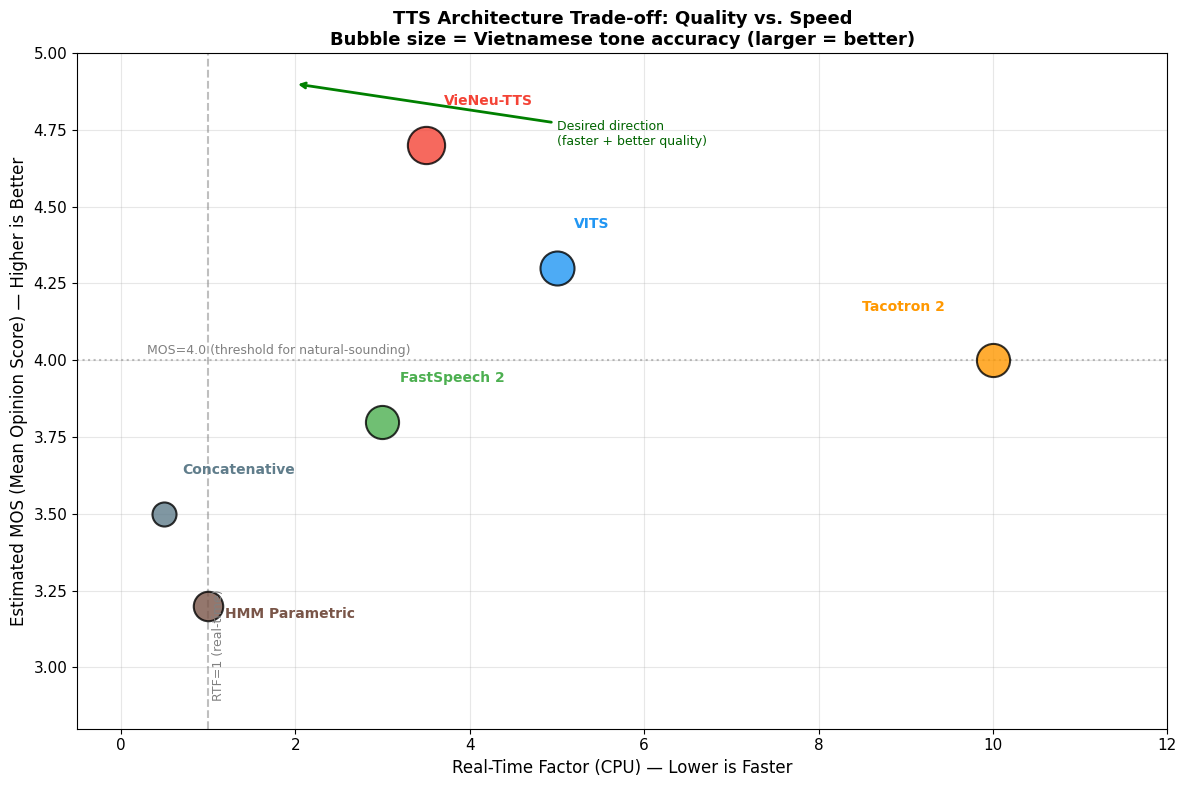


Conclusion:
  VieNeu-TTS achieves the best quality AND Vietnamese tone accuracy.
  It trades off some speed (autoregressive) for the LLM's language understanding.
  For production: use streaming + GPU to achieve real-time performance.

Next steps:
  Chapter 04: NeuCodec — Neural Audio Codec Architecture and Training
  Chapter 05: VieNeu Language Model — Transformer Architecture for TTS
  Chapter 06: Training VieNeu-TTS from Scratch on Vietnamese Data


In [11]:
# Visualize the quality vs latency trade-off across architectures

fig, ax = plt.subplots(figsize=(12, 8))

systems = [
    {"name": "Concatenative",  "rtf": 0.5,  "quality": 3.5, "viet_tone": 2.0, "size": 100, "color": "#607D8B"},
    {"name": "HMM Parametric", "rtf": 1.0,  "quality": 3.2, "viet_tone": 3.0, "size": 100, "color": "#795548"},
    {"name": "Tacotron 2",     "rtf": 10.0, "quality": 4.0, "viet_tone": 3.8, "size": 200, "color": "#FF9800"},
    {"name": "FastSpeech 2",   "rtf": 3.0,  "quality": 3.8, "viet_tone": 3.8, "size": 200, "color": "#4CAF50"},
    {"name": "VITS",           "rtf": 5.0,  "quality": 4.3, "viet_tone": 4.0, "size": 200, "color": "#2196F3"},
    {"name": "VieNeu-TTS",     "rtf": 3.5,  "quality": 4.7, "viet_tone": 4.8, "size": 400, "color": "#F44336"},
]

# Quality vs RTF bubble chart
# Bubble size = Vietnamese tone quality
for sys in systems:
    scatter = ax.scatter(sys["rtf"], sys["quality"],
                         s=sys["viet_tone"] * 150,  # bubble size = tone quality
                         c=sys["color"],
                         alpha=0.8, edgecolors='black', linewidth=1.5,
                         zorder=3)
    offset_x = 0.2
    offset_y = 0.05
    if sys['name'] == 'HMM Parametric':
        offset_y = -0.12
    if sys['name'] == 'Tacotron 2':
        offset_x = -1.5
        offset_y = 0.08
    ax.annotate(sys["name"],
                xy=(sys["rtf"], sys["quality"]),
                xytext=(sys["rtf"] + offset_x, sys["quality"] + offset_y + 0.08),
                fontsize=10, fontweight='bold', color=sys["color"],
                ha='left')

# Reference lines
ax.axvline(1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(1.05, 2.9, 'RTF=1 (real-time)', fontsize=9, color='gray', rotation=90)
ax.axhline(4.0, color='gray', linestyle=':', alpha=0.5, linewidth=1.5)
ax.text(0.3, 4.02, 'MOS=4.0 (threshold for natural-sounding)', fontsize=9, color='gray')

ax.set_xlabel("Real-Time Factor (CPU) — Lower is Faster", fontsize=12)
ax.set_ylabel("Estimated MOS (Mean Opinion Score) — Higher is Better", fontsize=12)
ax.set_title("TTS Architecture Trade-off: Quality vs. Speed\n"
             "Bubble size = Vietnamese tone accuracy (larger = better)",
             fontsize=13, fontweight='bold')
ax.set_xlim(-0.5, 12)
ax.set_ylim(2.8, 5.0)
ax.set_xscale('linear')
ax.grid(True, alpha=0.3)

# Arrow showing desired direction
ax.annotate('Desired direction\n(faster + better quality)', xy=(2.0, 4.9),
            xytext=(5, 4.7),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=9, color='darkgreen')

plt.tight_layout()
plt.savefig('ch03_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConclusion:")
print("  VieNeu-TTS achieves the best quality AND Vietnamese tone accuracy.")
print("  It trades off some speed (autoregressive) for the LLM's language understanding.")
print("  For production: use streaming + GPU to achieve real-time performance.")
print()
print("Next steps:")
print("  Chapter 04: NeuCodec — Neural Audio Codec Architecture and Training")
print("  Chapter 05: VieNeu Language Model — Transformer Architecture for TTS")
print("  Chapter 06: Training VieNeu-TTS from Scratch on Vietnamese Data")

## Summary

We traced the evolution of TTS from the 1990s to 2024:

| Era | Core Idea | Vietnamese Challenge | Solution |
|-----|-----------|--------------------|---------|
| **Concatenative** | Record + concatenate speech units | Huge inventory for 6 tones | Expensive corpus collection |
| **HMM Parametric** | Statistical model of acoustic features | Over-smoothing blurs tone F0 | MLPG + better feature modeling |
| **Tacotron 2** | Seq2seq with attention alignment | Attention fails at tone boundaries | Location-sensitive attention |
| **FastSpeech 2** | Non-autoregressive with duration predictor | Pitch predictor must learn 6 F0 contours | Separate pitch/duration/energy predictors |
| **VITS** | End-to-end VAE+GAN | Phonation type modeling | GAN discriminator enforces natural phonation |
| **VieNeu-TTS** | LLM + neural codec | Code-switching, zero-shot cloning | LLM understands language; codec discretizes speech |

**The key architectural insight**: Vietnamese TTS has always been harder than English TTS due to the 6-tone system requiring both F0 contour AND phonation type modeling. The LLM approach naturally solves this because:
1. The LLM understands tone marks as linguistic features (from text pretraining)
2. The NeuCodec first codebook encodes tonal information in the discrete speech tokens
3. In-context learning enables zero-shot speaker adaptation without any architectural changes

Continue to **Chapter 04** to learn about the NeuCodec neural audio codec that makes LLM-TTS possible.